In [5]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, \
                                    MaxPooling2D, BatchNormalization, Activation, \
                                    concatenate, Input, GlobalAveragePooling2D, \
                                    BatchNormalization, Flatten, Add, Input, InputLayer, \
                                    Activation, AveragePooling2D, Multiply

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

import cv2
import numpy as np

In [6]:
name = tf.test.gpu_device_name()

input_shape=(36, 36, 3, 2)
hidden_units=128
output_size=(1, )

batch_size = 64

sec = 15
ecg_fps = 256
video_fps = 61

# DataSet

In [7]:
def lgth_transform(ecg, ws):
    lgth=ecg.shape[0]
    sqr_diff=np.zeros(lgth)
    diff=np.zeros(lgth)
    ecg=np.pad(ecg, ws, 'edge')
    for i in range(lgth):
        temp=ecg[i:i+ws+ws+1]
        left=temp[ws]-temp[0]
        right=temp[ws]-temp[-1]
        diff[i]=min(left, right)
        diff[diff<0]=0

    return np.multiply(diff, diff)

def integrate(ecg, ws):
    lgth=ecg.shape[0]
    integrate_ecg=np.zeros(lgth)
    ecg=np.pad(ecg, math.ceil(ws/2), mode='symmetric')
    for i in range(lgth):
        integrate_ecg[i]=np.sum(ecg[i:i+ws])/ws
    return integrate_ecg

def find_peak(data, ws):
    lgth=data.shape[0]
    true_peaks=list()
    for i in range(lgth-ws+1):
        temp=data[i:i+ws]
        if np.var(temp)<5:
            continue
        index=int((ws-1)/2)
        peak=True
        for j in range(index):
            if temp[index-j]<=temp[index-j-1] or temp[index+j]<=temp[index+j+1]:
                peak=False
                break

        if peak is True:
            true_peaks.append(int(i+(ws-1)/2))
    return np.asarray(true_peaks)

def find_R_peaks(ecg, peaks, ws):
    num_peak=peaks.shape[0]
    R_peaks=list()
    for index in range(num_peak):
        i=peaks[index]
        if i-2*ws>0 and i<ecg.shape[0]:
            temp_ecg=ecg[i-2*ws:i]
            R_peaks.append(int(np.argmax(temp_ecg)+i-2*ws))
    return np.asarray(R_peaks)

def EKG_QRS_detect(ecg, fs):
    sig_lgth=ecg.shape[0]
    ecg=ecg-np.mean(ecg)
    ecg_lgth_transform=lgth_transform(ecg, int(fs/20))

    ws=int(fs/8)
    ecg_integrate=integrate(ecg_lgth_transform, ws)/ws
    ws=int(fs/6)
    ecg_integrate=integrate(ecg_integrate, ws)
    ws=int(fs/36)
    ecg_integrate=integrate(ecg_integrate, ws)
    ws=int(fs/72)
    ecg_integrate=integrate(ecg_integrate, ws)

    peaks=find_peak(ecg_integrate, int(fs/10))
    R_peaks=find_R_peaks(ecg, peaks, int(fs/40))
    
    return R_peaks

    
def get_HR(ecg, fs=256, sec=15):
    R_peaks = EKG_QRS_detect(ecg, fs)
    
    return len(R_peaks) * (60 / sec)

In [8]:
def iter_video(path):
    cap = cv2.VideoCapture(path)
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    for i in range(length // fps):
        X = list()
        
        for j in range(fps * sec):
            ret, frame = cap.read()
            X.append(frame)
        
        yield np.asarray(X)
    
    cap.release()

def iter_ecg(path):
    data = np.load(path)
    seg_length = sec * ecg_fps
    iter_length = len(data) // seg_length
    
    for i in range(iter_length):
        Y = get_HR(data[i*seg_length : (i+1) * seg_length], ecg_fps, sec)
        
        yield Y

## Generator

In [9]:
def trainGenerator():
    base = os.path.join(os.getcwd(), 'data', 'train')
    X_paths = list()
    
    for folder in os.listdir(base):
        for file in os.listdir(os.path.join(base, folder)):
            if file.endswith('avi'):
                X = os.path.join(base, folder, file)
            elif file.endswith('npy'):
                Y = np.load(os.path.join(base, folder, file))
        
        for x, y in zip(iter_video(X), iter_ecg(Y)):
            yield (x, y)

def valGenerator():
    base = os.path.join(os.getcwd(), 'data', 'val')
    X_paths = list()
    
    for folder in os.listdir(base):
        for file in os.listdir(os.path.join(base, folder)):
            if file.endswith('avi'):
                X = os.path.join(base, folder, file)
            elif file.endswith('npy'):
                Y = np.load(os.path.join(base, folder, file))
        
        for x, y in zip(iter_video(X), iter_ecg(Y)):
            yield (x, y)

def testGenerator():
    base = os.path.join(os.getcwd(), 'data', 'test')
    X_paths = list()
    
    for folder in os.listdir(base):
        for file in os.listdir(os.path.join(base, folder)):
            if file.endswith('avi'):
                X = os.path.join(base, folder, file)
            elif file.endswith('npy'):
                Y = np.load(os.path.join(base, folder, file))
        
        for x, y in zip(iter_video(X), iter_ecg(Y)):
            yield (x, y)

In [10]:
with tf.device(name):
    train_dataset  = tf.data.Dataset.from_generator(
        trainGenerator, \
        (tf.int32, tf.float32), \
        (tf.TensorShape(input_shape), tf.TensorShape(output_size)))

    train_dataset = train_dataset.batch(batch_size).prefetch(1)

    val_dataset  = tf.data.Dataset.from_generator(
        valGenerator, \
        (tf.int32, tf.float32), \
        (tf.TensorShape(input_shape), tf.TensorShape(output_size)))

    val_dataset = val_dataset.batch(batch_size).prefetch(1)

    test_dataset  = tf.data.Dataset.from_generator(
        valGenerator, \
        (tf.int32, tf.float32), \
        (tf.TensorShape(input_shape), tf.TensorShape(output_size)))

    test_dataset = test_dataset.batch(batch_size).prefetch(1)

# Design Model

In [16]:
def build_model(input_shape=(36, 36, 3, 2), drop_rate=0.3, hidden_units=128, output_size=1):
    input_layer = Input(input_shape)
    cur_input_layer, next_input_layer = \
                                [tf.squeeze(layer, axis=-1) for layer in tf.split(input_layer, num_or_size_splits=2, axis=-1)]
                                    
    # Appearance Model
    appr_layer1 = Conv2D(32, (3, 3), activation='tanh', padding='same', name='appr_layer1')(cur_input_layer)
    appr_layer2 = Conv2D(32, (3, 3), activation='tanh', padding='same', name='appr_layer2')(appr_layer1)
    
    appr_norm1 = Conv2D(32, (1, 1), activation='sigmoid', padding='same', name='appr_layer2-norm')(appr_layer2)
    conv_sum1 = backend.sum(backend.sum(appr_norm1, axis=1), axis=1)
    appr_norm1 = appr_norm1.shape[1] * appr_norm1.shape[2] * appr_norm1 / (2 * conv_sum1)
    
    appr_layer3 = AveragePooling2D(name='appr_layer3-pool')(appr_layer2)
    appr_layer3 = Conv2D(32, (2, 2), activation='tanh', padding='same', name='appr_layer3-conv')(appr_layer3)
    appr_layer4 = Conv2D(32, (3, 3), activation='tanh', padding='same', name='appr_layer4')(appr_layer3)
    appr_layer5 = Conv2D(64, (3, 3), activation='tanh', padding='same', name='appr_layer5')(appr_layer4)
    
    appr_norm2 = Conv2D(64, (1, 1), activation='sigmoid', padding='same', name='appr_layer5-norm')(appr_layer5)
    conv_sum2 = backend.sum(backend.sum(appr_norm2, axis=1), axis=1)
    appr_norm2 = appr_norm2.shape[1] * appr_norm2.shape[2] * appr_norm2 / (2 * conv_sum2)
    
    # Motion Model
    # Layer 1
    motion_input_layer = (next_input_layer - cur_input_layer) / \
                            (next_input_layer + cur_input_layer)
    layer1 = Conv2D(32, (3, 3), activation='tanh', padding='same', name='motion_layer1')(motion_input_layer)
    
    # Layer 2
    layer2 = Conv2D(32, (3, 3), activation='tanh', padding='same', name='motion_layer2')(layer1)
    
    # L1 normalization
    motion_norm1 = Multiply(name='motion_layer2-norm')([appr_norm1, layer2])
    
    # Layer 3
    layer3 = AveragePooling2D(name='motion_layer3-pool')(motion_norm1)
    layer3 = Conv2D(32, (2, 2), activation='tanh', padding='same', name='motion_layer3-conv')(layer3)
    
    # Layer 4
    layer4 = Conv2D(32, (3, 3), activation='tanh', padding='same', name='motion_layer4')(layer3)
    
    # Layer 5
    layer5 = Conv2D(64, (3, 3), activation='tanh', padding='same', name='motion_layer5')(layer4)
    
    # L1 normalization
    motion_norm2 = Multiply(name='motion_layer5-norm')([appr_norm2, layer5])
    
    # Layer 6
    layer6 = AveragePooling2D(name='motion_layer6-pool')(motion_norm2)
    layer6 = Conv2D(64, (2, 2), activation='tanh', padding='same', name='motion_layer6-conv')(layer6)
    
    # Layer 7
    layer7 = Flatten(name='motion_layer7')(layer6)
    
    # Layer 8
    layer8 = Dense(hidden_units, activation='relu', name='motion_layer8')(layer7)
    
    # Layer 9
    output_layer = Dense(output_size, activation='relu', name='motion_output_layer')(layer8)
    
    return Model(input_layer, output_layer)

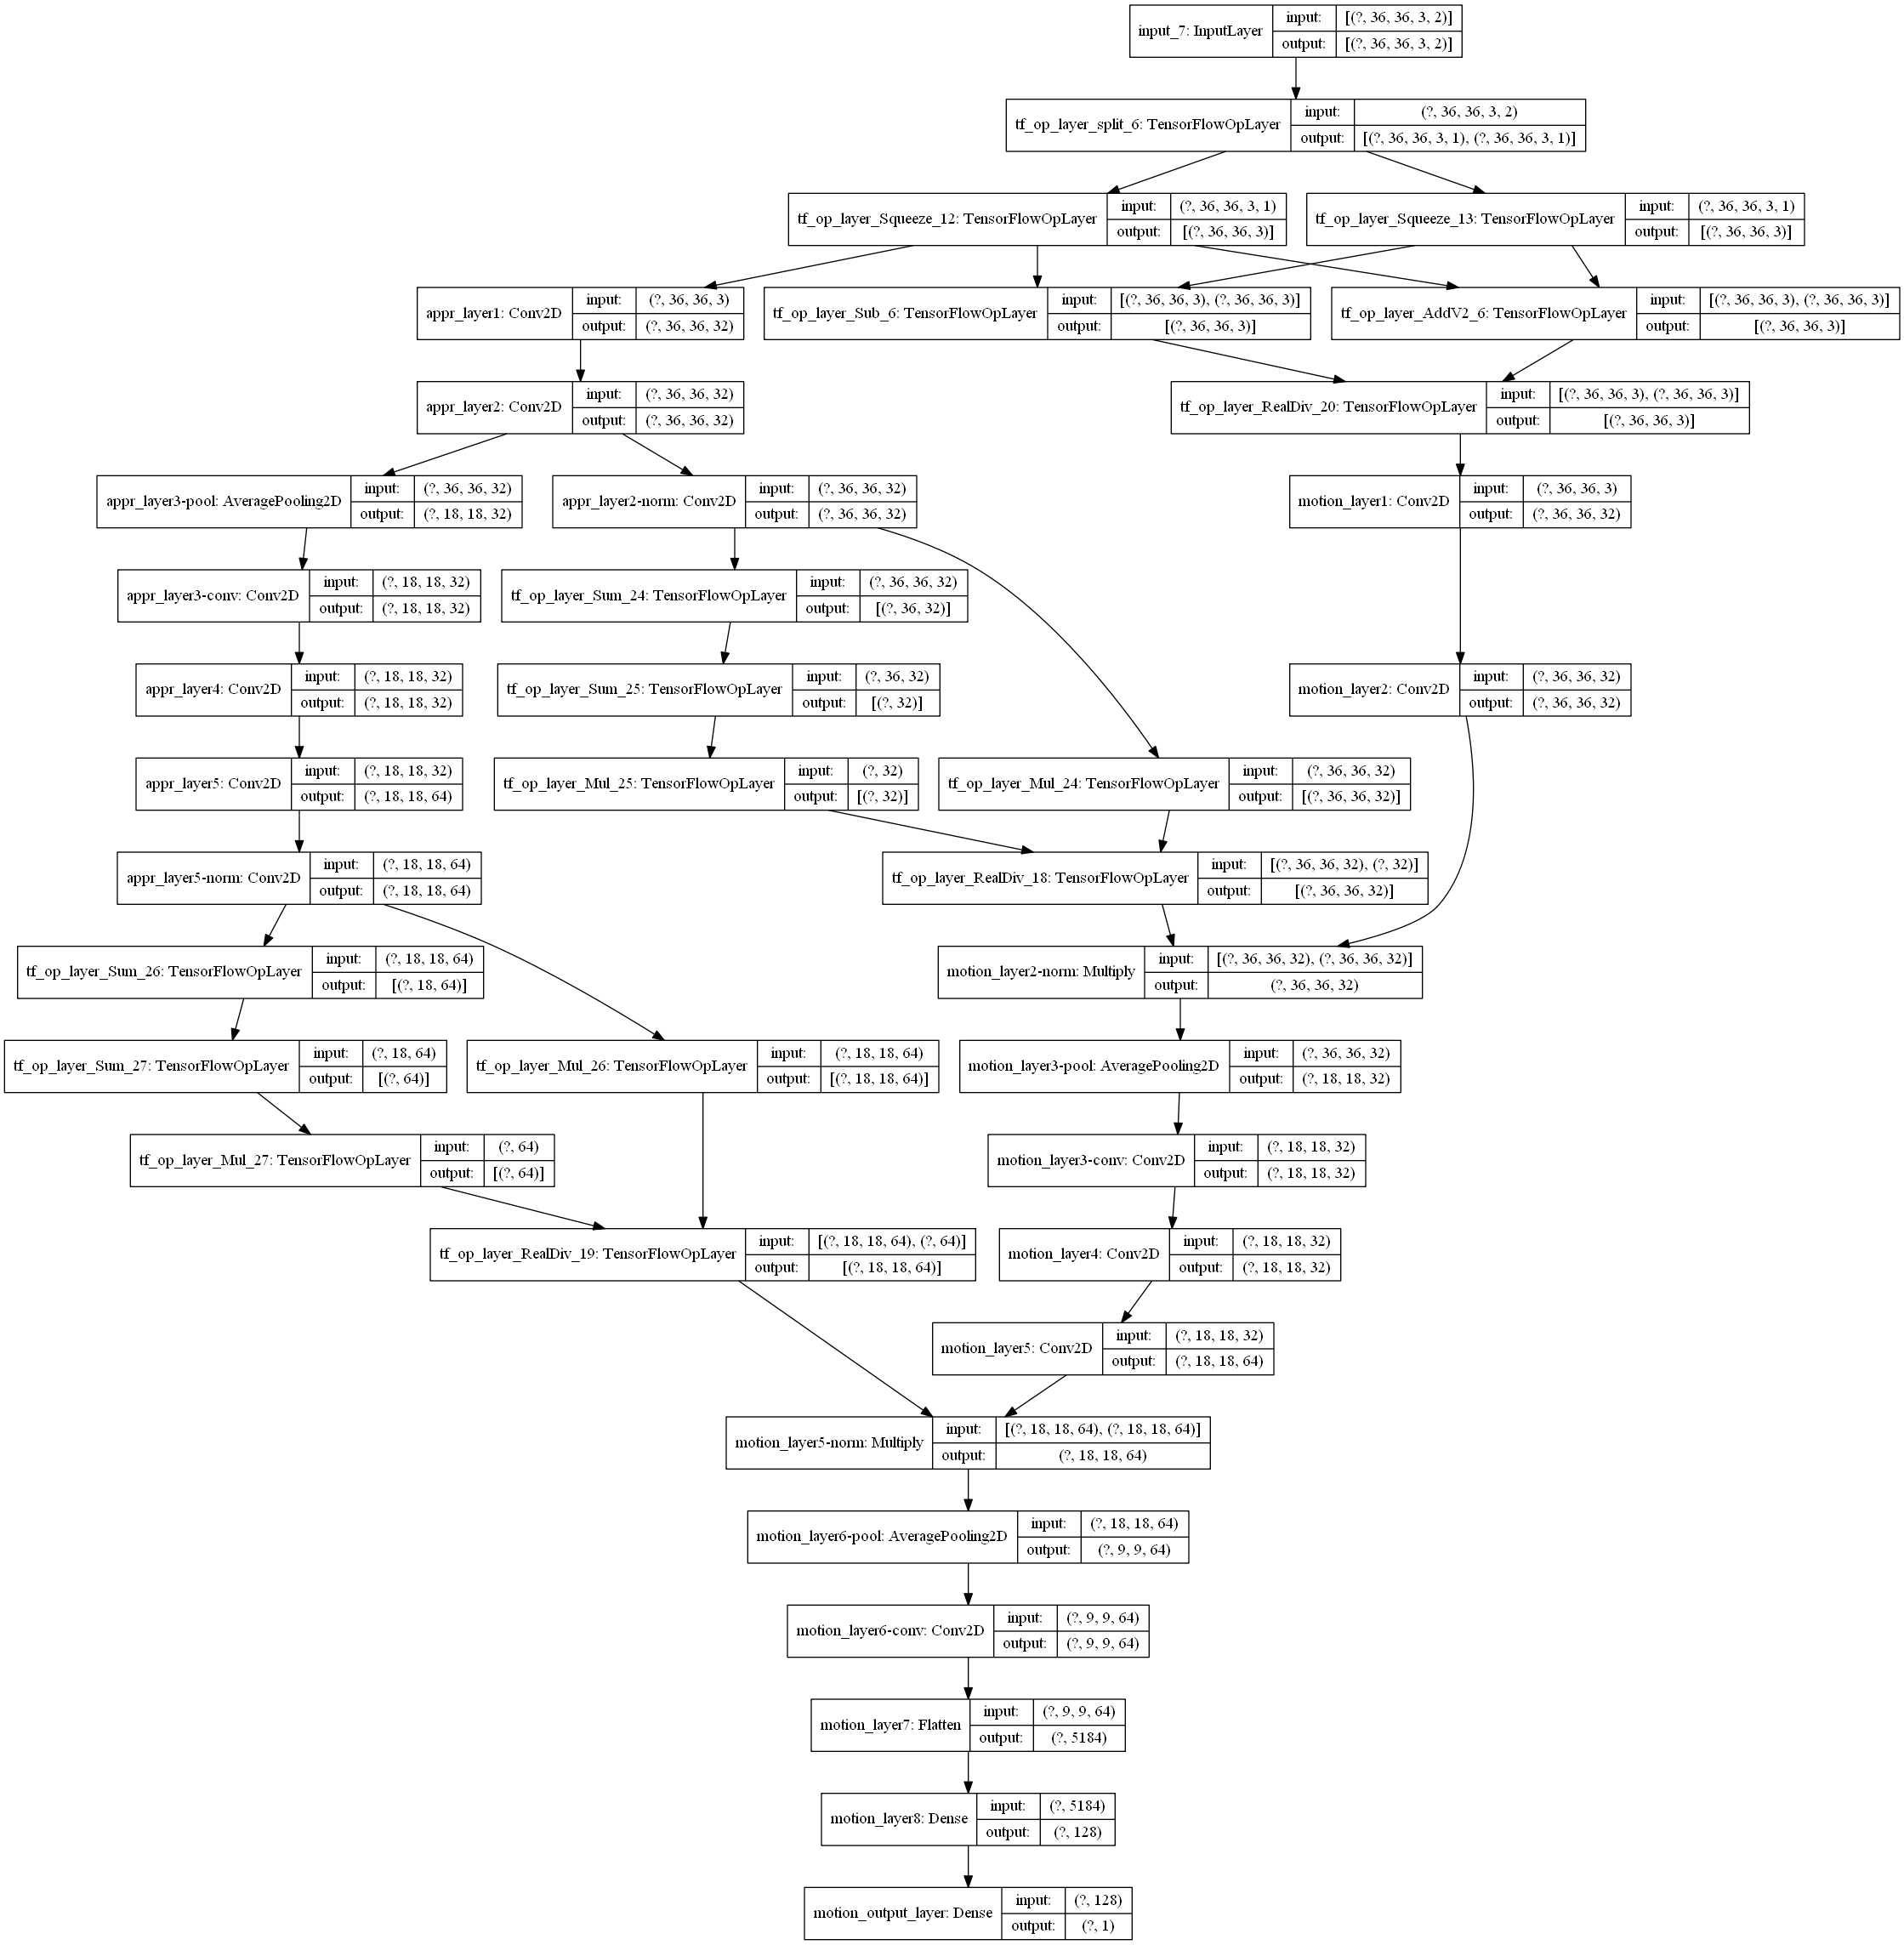

In [17]:
with tf.device(name):
    model = build_model()
    model.compile(optimizer=Adam(1e-3), loss=MeanSquaredError(), metrics=['mse', 'mae', 'rmse'])
    plot_model(model, show_shapes=True, to_file='model.png')
# model.summary()

# Train

In [13]:
# 모델 폴더를 생성합니다.
model_path = 'model/'
if not os.path.exists(model_path):
    os.mkdir(model_path)

# Validation 점수가 가장 좋은 모델만 저장합니다.
model_file_path = model_path + 'Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath=model_file_path, monitor='val_loss', verbose=1, save_best_only=True)

# 10회 간 Validation 점수가 좋아지지 않으면 중지합니다.
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
with tf.device(name):
    history = model.fit(train_dataset, validation_data=val_dataset,
                        epochs=200, 
                        callbacks=[checkpoint, early_stopping])

In [ ]:
print(model.evaluate(test_dataset))